In [3]:
!pip install --upgrade kaggle
!pip install --upgrade OpenCV-python
from google.colab import files
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from skimage.morphology import label
import numpy as np
import cv2
from skimage import io
import os

    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 235kB 4.8MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/44/2c/df/22a6eeb780c36c28190faef6252b739fdc47145fd87a6642d4
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify
Requirement already up-to-date: OpenCV-python in /usr/local/lib/python3.6/dist-packages (3.4.2.17)


In [5]:
import os.path
areFilesDownloaded = os.path.isfile('kaggle.json')
if not areFilesDownloaded:
  # upload kaggle.json here
  from google.colab import files
  uploaded = files.upload()

  # The Kaggle API client expects this file to be in ~/.kaggle,
  # so move it there.
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/

  # This permissions change avoids a warning on Kaggle tool startup.
  !chmod 600 /root/.kaggle/kaggle.json
  
  # List available datasets.
  !kaggle competitions files -c airbus-ship-detection

  #download all and unzip training set
  !kaggle competitions download -c airbus-ship-detection -p /content/kaggle
  
  !mkdir train
  !mkdir test

  
trainPath = "train/"
trainArchive = zipfile.ZipFile('kaggle/train.zip','r')

if not areFilesDownloaded:
  trainArchive.extractall(trainPath)

Saving kaggle.json to kaggle.json
name                          size  creationDate         
----------------------------  ----  -------------------  
test_ship_segmentations.csv   14MB  2018-08-30 21:23:35  
sample_submission.csv          2MB  2018-08-30 21:23:49  
train_ship_segmentations.csv  29MB  2018-08-30 21:23:49  
test.zip                      12GB  2018-08-30 21:23:50  
train.zip                     14GB  2018-08-30 21:23:50  
 85%|████████████████████████████████▎     | 5.00M/5.87M [00:00<00:00, 25.3MB/s]
100%|██████████████████████████████████████| 5.87M/5.87M [00:00<00:00, 29.2MB/s]
  0%|                                                | 0.00/448k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 448k/448k [00:00<00:00, 92.6MB/s]
 41%|███████████████▊                      | 5.00M/12.1M [00:00<00:00, 9.99MB/s]
100%|██████████████████████████████████████| 12.1M/12.1M [00:00<00:00, 23.0MB/s]
100%|█████████████████████████████████████▉| 12.2G/12.2G [04:45<00:00, 64.

In [6]:
segments = pd.read_csv("kaggle/train_ship_segmentations.csv.zip",compression = "zip")
trainImages = pd.DataFrame({'ImageId':trainArchive.namelist()})

shipsCounted = segments[segments["EncodedPixels"].isna()==False].groupby("ImageId").count()

trainImages = trainImages.merge(shipsCounted,right_index= True,left_on='ImageId',how='outer')
trainImages.rename(index = str,columns = {'EncodedPixels':"shipCount"},inplace=True)
trainImages.loc[trainImages['shipCount'].isna(),['shipCount']] = 0
trainImages.drop(trainImages[trainImages['ImageId'] == '6384c3e78.jpg'].index,inplace = True) #remove corrupted image
print(trainImages['shipCount'].describe())

count    104069.000000
mean          0.538393
std           1.337665
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          15.000000
Name: shipCount, dtype: float64


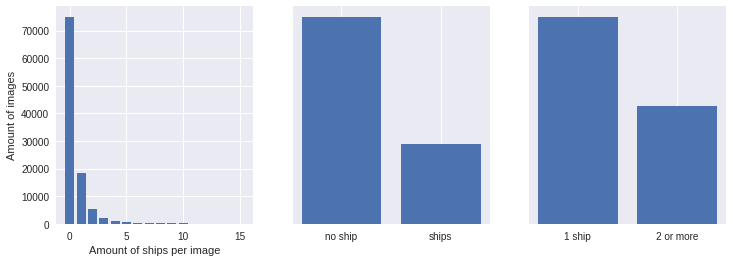

Little augmentation hihi


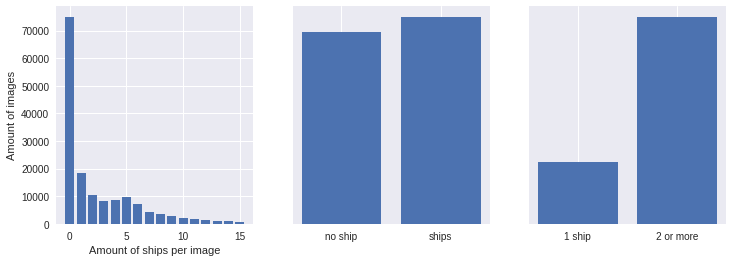

count    155980.000000
mean          2.336383
std           3.284019
min           0.000000
25%           0.000000
50%           1.000000
75%           4.000000
max          15.000000
Name: shipCount, dtype: float64


In [7]:
def plotCount(bars):
  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.bar(bars.index.values,bars["ImageId"])
  plt.xlabel("Amount of ships per image")
  plt.ylabel("Amount of images")

  plt.subplot(132)
  plt.yticks([])
  plt.xticks([0,1],['no ship','ships'])
  plt.bar([0,1],[bars['ImageId'][0],bars['ImageId'][1:].sum()])

  plt.subplot(133)
  plt.yticks([])
  plt.xticks([0,1],['1 ship','2 or more'])
  plt.bar([0,1],[bars['ImageId'][1],bars['ImageId'][2:].sum()])
  plt.show()
  
  
plotCount(bars = trainImages.groupby('shipCount').count())

#make cheap balancing
print('Little augmentation hihi')
for i in range(1,5,1):
  trainImages = pd.concat([trainImages,trainImages[trainImages['shipCount']>i]],ignore_index=True)

trainImages = trainImages.sample(frac=1)
plotCount(bars = trainImages.groupby('shipCount').count())
print(trainImages['shipCount'].describe())


In [0]:
def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks
  
def getTrainImage(imageID):
    return np.array([io.imread(trainPath+x)for x in imageID])
  
def getMask(imageID):
    output = []
    for a in imageID:
        masksRLE = segments[segments["ImageId"] == a]["EncodedPixels"].values
        mask = np.zeros((768, 768))
        if str(masksRLE[0]) != 'nan':
          mask = masks_as_image(masksRLE)
        output.append(mask)
    return np.array(output)



In [9]:
from keras.models import Input, Model
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout

dropoutRate = 0.25

def convBlock(x,kernels):
    conv = Conv2D(kernels, (3, 3), padding="same")(x)
    activated = Activation("relu")(conv)
    normalised = BatchNormalization(axis=-1)(activated)
    dropout = Dropout(dropoutRate)(normalised)
    return dropout

def buildModel():
    x = Input(shape=(768, 768, 3))
    conv1 = convBlock(x,16)
    output = MaxPooling2D(pool_size=(3,3))(conv1)

    conv2 = convBlock(output,32)
    output = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = convBlock(output,64)
    output = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = convBlock(output,128)
    output = MaxPooling2D(pool_size=(2,2))(conv4)

    conv5 = convBlock(output,64)
    output = MaxPooling2D(pool_size=(2,2))(conv5)

    output = convBlock(output,128)
    output = convBlock(output,128) 

    output = convBlock(UpSampling2D((2, 2))(output),128)
    output = concatenate([output, conv5])
    
    output = convBlock(UpSampling2D((2, 2))(output),128)
    output = concatenate([output, conv4])

    output = convBlock(UpSampling2D((2, 2))(output),64)
    output = concatenate([output, conv3])

    output = convBlock(UpSampling2D((2, 2))(output),32)
    output = concatenate([output, conv2])

    output = convBlock(UpSampling2D((3,3))(output),16)
    output = concatenate([output, conv1])
    
    output = Conv2D(1, (1, 1), padding="same")(output)
    output = Activation("sigmoid")(output)

    model = Model(input=x, output=output)
#     print(model.summary())
    return model

Using TensorFlow backend.


In [0]:

model = buildModel()

files.upload()
model.load_weights('model.h5')

from keras.optimizers import Adam
model.compile(optimizer = Adam(lr=1e-4), 
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])



In [0]:
LargeBatchSize = 500
SmallBatchSize = 5

def getLargeBatchImages(i):
  global trainImages
  if trainImages.size> (i+1)*LargeBatchSize:
    return trainImages['ImageId'][i*LargeBatchSize:(i+1)*LargeBatchSize]
  else:
    output = trainImages['ImageId'][(i-0.5)*LargeBatchSize:] 
    trainImages = trainImages.sample(frac=1)
    return output

def downloadModel():
  model.save('model.h5')
  files.download('model.h5')

In [0]:
import gc
gc.collect()
trainImages = trainImages.sample(frac=1)
epoch = 1
epochPerImageLoad = 3
parts = int(trainImages.size/LargeBatchSize+1)
for e in range(epoch):
  for i in range(parts):
    print("Part: "+str(i)+"/"+str(parts)+". Loading "+str(LargeBatchSize)+" images.")  
    imageIDs = getLargeBatchImages(i)
    images = getTrainImage(imageIDs)
    masks = np.expand_dims(getMask(imageIDs),axis=-1)
    gc.collect()
    model.fit(images,masks,epochs = epochPerImageLoad,shuffle=True,batch_size = SmallBatchSize) 
  
  if i%10 == 1:
    try:
      downloadModel()
    except:
      continue

In [12]:
# uncomment below to wipe notebook memory 
# !kill -9 -1
!ls

kaggle	kaggle.json  model.h5  sample_data  test  train


In [0]:
downloadModel()

In [0]:
def validate(x):
  global model
  global trainImages
  images = getTrainImage(trainImages["ImageId"].sample(x))
  masks = (model.predict(images)).squeeze()
  masks[:,0,0] = 1 #set a reference pixel
  for i in range(x):
    plt.figure(figsize=(16,8))
    
    plt.subplot(121)
    io.imshow(images[i])
    
    plt.subplot(122)
    img = io.imshow(masks[i])
    img.set_cmap('coolwarm')
    
    plt.show()
  

In [17]:
validate(20)

In [0]:
testPath = "test/"
testArchive = zipfile.ZipFile('kaggle/test.zip','r')
if not areFilesDownloaded:
  testArchive.extractall(testPath)

In [0]:
testImages = testArchive.namelist()
result = []

# emergency - find already labeled images


In [20]:
div = len(testImages)/100

for i,id in enumerate(testImages):
  if i%div==0:
    print(str(i*100/len(testImages))+"%")
  image = io.imread(testPath+id)
  mask = (model.predict(np.expand_dims(np.array(image),axis=0))).squeeze()
  masks = multi_rle_encode(mask>0.6)
  if len(masks)==0:
    result.append([id,])
  for m in masks:
    result.append([id,m])

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%


In [0]:
final = pd.DataFrame(result,columns = ['ImageId','EncodedPixels'])

In [0]:
final.to_csv('final.csv',index = False)
files.download('final.csv')

In [0]:
files.download('final.csv')